(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import ActiveInference as AI

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# Ising models - Monte Carlo simulations

This notebook accompanies a series of notes based on David MacKay's book
chapters on the Ising model. In this notebook, we will explore the Ising model
via Monte Carlo simulations.

## The Ising model

Ising models are a simple model of ferromagnetism. The model consists of an
array of spins that can be in one of two states, up or down (or +1 or -1). The
spins are magnetically coupled to their neighbors with two possible types of
couplings: 
- ferromagnetic (like spins want to align) or 
- antiferromagnetic (like spins want to anti-align).

Let the state $\underline{x}$ of an ising model with $N$ spins be a vector in
which each element $x_n$ is the state of the $n$-th spin. If two spins are
neighbors, we write $(m, n) \in \mathcal{N}$. The coupling energy for a pair of
spins is defined as
$$
J_{mn} = \begin{cases}
J & \text{if } (m, n) \in \mathcal{N}\\
0 & \text{otherwise}
\end{cases}.
\tag{1}
$$
The energy of any state $\underline{x}$, also called the Hamiltonian, is defined
as
$$
E(\underline{x}; J, H) = - \frac{1}{2} \left[
    \sum_{m, n} J_{mn} x_m x_n + H \sum_n x_n,
\right],
\tag{2}
$$
where $H$ is an externally applied field. If $J > 0$ the model is ferromagnetic,
and if $J < 0$ the model is antiferromagnetic. The $1/2$ factor comes from the
double counting of the energy of each pair of spins, once as $(m, n)$ and once
as $(n, m)$. At equilibrium temperature $T$, the probability of a state
$\underline{x}$ is given by the Boltzmann distribution
$$
P(\underline{x} \mid \beta, J, H) = \frac{1}{\mathcal{Z}} \exp\left(
    -\beta E(\underline{x}; J, H)
\right),
\tag{3}
$$
where $\beta = 1 / k_B T$ is the inverse temperature, and $\mathcal{Z}$ is the
partition function, defined as
$$
\mathcal{Z} = \sum_{\underline{x}} \exp\left(
    -\beta E(\underline{x}; J, H)
\right).
\tag{4}
$$

## Monte Carlo simulations

### Gibbs sampling

Let us study a two-dimensional planar Ising model with periodic boundary using a
simple Gibbs sampling Monte Carlo simulation. The algorithm is as follows:

1. Initialize the spins randomly.
2. Select a spin $n$ at random.
3. The probability of having spin $x_n = 1$ is should be given by the state of
   the other spins and the temperature. This probability is computed as
    $$
    P(x_n = 1 \mid b_n) = \frac{1}{1 + \exp(-2 \beta b_n)},
    \tag{5}
    $$
    where $b_n$ is the local field acting on spin $n$, given by
    $$
    b_n = \sum_{m \in \mathcal{N}_n} J_{mn} x_m + H.
    \tag{6}
    $$
    The factor of 2 appears because the states are ${\pm 1}$ and not ${0, 1}$.
4. Generate a random number $r$ between 0 and 1. If $r < P(x_n = 1 \mid b_n)$,
   set $x_n = 1$, otherwise set $x_n = -1$.
5. Repeat steps 2-4 for a number of iterations.

After enough iterations, the system will reach equilibrium.

#### Rectangular lattice

For our simulation, we will consider a $L \times L$ square lattice with periodic
boundary conditions. Let's start by defining a function to compute the energy of
a given state of this lattice.

In [11]:
"""
    E_rectangular(x̲::Matrix, J::Number, H::Number)

Compute the energy of a configuration in the Ising model on a rectangular
lattice.

# Arguments
- `x̲::Matrix`: a matrix representing the spin configuration. Each element is +1
  or -1.
- `J`: the coupling constant. Positive for ferromagnetic coupling, negative for
  antiferromagnetic.
- `H`: the external magnetic field.

# Returns
- The energy of the configuration.

# Notes
- The function uses periodic boundary conditions.
- The energy is computed as -J ∑ x̲[i, j] x̲[i', j'] - H ∑ x̲[i, j], where the
  first sum is over all pairs of neighboring spins and the second sum is over
  all spins.
"""
function E_rectangular(x̲::Matrix, J, H)
    # Get the size of the spin configuration matrix
    m, n = size(x̲)
    # Initialize the energy to zero
    energy = 0.0

    # Compute the coupling energy between neighboring spins
    for i in 1:m
        for j in 1:n
            # Apply periodic boundary conditions
            # If i > 1, then im1 = i - 1, else im1 = m (the last row)
            im1 = i > 1 ? i - 1 : m
            # If i < m, then ip1 = i + 1, else ip1 = 1 (the first row)
            ip1 = i < m ? i + 1 : 1
            # If j > 1, then jm1 = j - 1, else jm1 = n (the last column)
            jm1 = j > 1 ? j - 1 : n
            # If j < n, then jp1 = j + 1, else jp1 = 1 (the first column)
            jp1 = j < n ? j + 1 : 1

            # Subtract the energy contribution from the neighbor below
            energy -= J * x̲[i, j] * x̲[ip1, j]
            # Subtract the energy contribution from the neighbor to the right
            energy -= J * x̲[i, j] * x̲[i, jp1]
        end # for j
    end # for i

    # Subtract the energy contribution from the external field
    energy -= H * sum(x̲)

    # Return the total energy
    return energy
end

E_rectangular

Next, we need to define a function to compute the local field acting on a spin.

In [12]:
"""
    local_field_rectangular(n::Int, x̲::Matrix, J, H)

Compute the local magnetic field at a given spin in the Ising model on a
rectangular lattice.

# Arguments
- `n::Int`: the linear index of the spin.
- `x̲::Matrix`: a matrix representing the spin configuration. Each element is +1
  or -1.
- `J`: the coupling constant. Positive for ferromagnetic coupling, negative for
  antiferromagnetic.
- `H`: the external magnetic field.

# Returns
- The local magnetic field at the spin.

# Notes
- The function uses periodic boundary conditions.
- The local field is computed as J ∑ x̲[i', j'] + H, where the sum is over the
  neighboring spins of the given spin.
"""
function local_field_rectangular(
    n::Int, x̲::Matrix, J, H,
)
    # Get the size of the spin configuration matrix
    m, n = size(x̲)

    # Convert the linear index to row and column indices
    i, j = Tuple(CartesianIndices(x̲)[n])

    # Apply periodic boundary conditions
    # If i > 1, then im1 = i - 1, else im1 = m (the last row)
    im1 = i > 1 ? i - 1 : m
    # If i < m, then ip1 = i + 1, else ip1 = 1 (the first row)
    ip1 = i < m ? i + 1 : 1
    # If j > 1, then jm1 = j - 1, else jm1 = n (the last column)
    jm1 = j > 1 ? j - 1 : n
    # If j < n, then jp1 = j + 1, else jp1 = 1 (the first column)
    jp1 = j < n ? j + 1 : 1

    # Compute the local field at the spin
    # This is the sum of the spins of the neighboring spins, multiplied by the coupling constant, plus the external field
    bₙ = J * (x̲[im1, j] + x̲[ip1, j] + x̲[i, jm1] + x̲[i, jp1]) + H

    # Return the local field
    return bₙ
end

local_field_rectangular

With these two functions in hand, we can now define a function to perform the
Gibbs sampling.

In [15]:
"""
    gibbs_sampling!(
        x̲::Matrix{<:Number}, n_iter::Int; 
        J::Number=1, H::Number=0, β::Number=1, 
        local_field::Function=local_field_rectangular
    )

Perform Gibbs sampling on a spin configuration in the Ising model.

# Arguments
- `x̲::Matrix`: a matrix representing the initial spin configuration. Each
  element is +1 or -1.
- `n_iter::Int`: the number of iterations to perform.

## Optional Keyword Arguments
- `J::Number`: the coupling constant. Positive for ferromagnetic coupling,
  negative for antiferromagnetic.
- `H::Number`: the external magnetic field.
- `β::Number`: the inverse temperature.
- `local_field::Function`: a function that computes the local magnetic field at
  a given spin.

# Returns
- The final spin configuration after `n_iter` iterations of Gibbs sampling.

# Notes
- The function modifies the input `x̲` in place.
- The function uses the Gibbs sampling algorithm, which is a type of Markov
  chain Monte Carlo (MCMC) algorithm.
- The local field is computed using the `local_field` function, which should
  take as arguments the linear index of the spin, the spin configuration matrix,
  the coupling constant, and the external field.
"""
function gibbs_sampling!(
    x̲::Matrix,
    n_iter::Int;
    J::Number=1,
    H::Number=0,
    β::Number=1,
    local_field::Function=local_field_rectangular
)
    # Get the size of the spin configuration matrix
    m, n = size(x̲)
    # Compute the total number of spins
    N = m * n

    # Perform Gibbs sampling for `n_iter` iterations
    for iter in 1:n_iter
        # Select a random spin
        spin_idx = rand(1:N)

        # Compute the local field acting on the selected spin
        b_n = local_field(spin_idx, x̲, J, H)

        # Compute the probability of the spin being +1
        # This is given by the logistic function of the local field, scaled by the inverse temperature
        p_up = 1 / (1 + exp(-2 * β * b_n))

        # Generate a random number
        r = rand()

        # Update the spin according to the generated number and the computed
        # probability If the number is less than the probability, the spin is
        # set to +1, otherwise it is set to -1
        if r < p_up
            x̲[spin_idx] = 1
        else
            x̲[spin_idx] = -1
        end
    end

    # Return the final spin configuration
    return x̲
end

gibbs_sampling!

Let's test the Gibbs sampling function by initializing a random state and
running the Gibbs sampling for a few iterations.

In [22]:
Random.seed!(42)

# Define latice size
m, n = 16, 16
# Define number of iterations
n_iter = 1_000
# Set initial state with random spins.
# NOTE: We use Int8 for low memory usage.
x_init = rand(Int8[-1, 1], m, n)

# Copy the initial state to the current state
x = deepcopy(x_init)

# Perform Gibbs sampling
gibbs_sampling!(x, n_iter)

16×16 Matrix{Int8}:
 1   1  1  1  1  1  1  1  -1  1  1  1  1  1  1  1
 1  -1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1
 1   1  1  1  1  1  1  1   1  1  1  1  1  1  1  1

Let's show the initial and final states of the lattice.

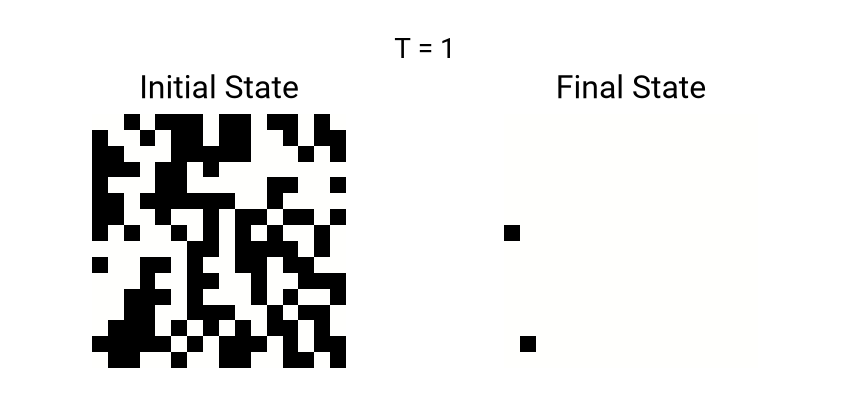

In [31]:
# Initialize figure
fig = Figure(size=(425, 200))

# Add global GridLayout
gl = fig[1, 1] = GridLayout()

# Add axes to the figure
axes = [
    Axis(gl[1, i], aspect=AxisAspect(1))
    for i in 1:2
]

# Plot the initial state
heatmap!(
    axes[1],
    x_init,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[1].title = "Initial State"

# Plot the final state
heatmap!(
    axes[2],
    x,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[2].title = "Final State"

# Hide decorations
hidedecorations!.(axes)

# Add title to the figure
Label(
    gl[1, :, Top()],
    "β = 1",
    valign=:bottom,
    font=:bold,
    padding=(0, 0, 25, 0)
)

fig

For this low temperature, the system is in a ferromagnetic phase, where the
spins tend to align with each other. The initial random configuration evolves
towards a more ordered state, with large domains of aligned spins.

Let's now increase the temperature and see how the system behaves.

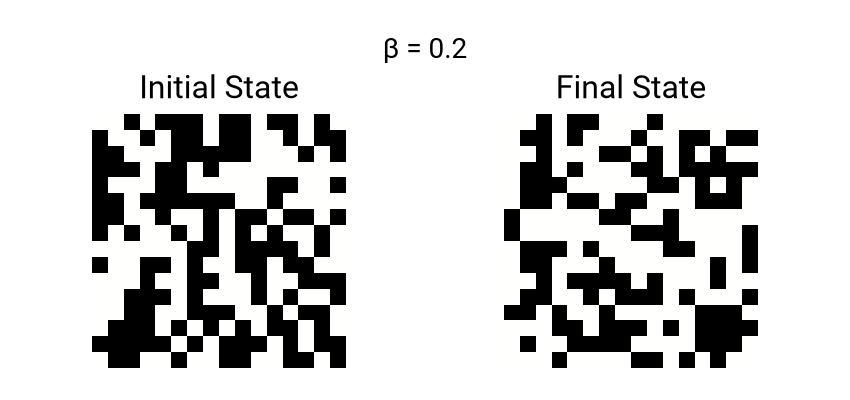

In [32]:
Random.seed!(42)

# Define inverse temperature
β = 1 / 5
# Define latice size
m, n = 16, 16
# Define number of iterations
n_iter = 1_000
# Set initial state with random spins.
# NOTE: We use Int8 for low memory usage.
x_init = rand(Int8[-1, 1], m, n)

# Copy the initial state to the current state
x = deepcopy(x_init)

# Perform Gibbs sampling
gibbs_sampling!(x, n_iter; β=β)

# Initialize figure
fig = Figure(size=(425, 200))

# Add global GridLayout
gl = fig[1, 1] = GridLayout()

# Add axes to the figure
axes = [
    Axis(gl[1, i], aspect=AxisAspect(1))
    for i in 1:2
]

# Plot the initial state
heatmap!(
    axes[1],
    x_init,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[1].title = "Initial State"

# Plot the final state
heatmap!(
    axes[2],
    x,
    colormap=ColorSchemes.grays,
    colorrange=(-1, 1),
    showaxis=false,
    showticks=false,
    transpose=true,
)

# Set title
axes[2].title = "Final State"

# Hide decorations
hidedecorations!.(axes)

# Add title to the figure
Label(
    gl[1, :, Top()],
    "β = $(round(β, digits=2))",
    valign=:bottom,
    font=:bold,
    padding=(0, 0, 25, 0)
)

fig

As expected, at higher temperatures (lower β), the spins are more likely to flip, leading to a more disordered state.